# IEOR 4501 Final Project: Understanding Hired Rides in NYC

#### Contributors: Joy Ren(jr4154), Yiwen Qian(yq2346)

## Project Setup

In [1]:
# all import statements needed for the project

import math
from math import sin, cos, sqrt, atan2, radians
import os
import warnings
import re
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import sqlalchemy as db
import geopandas as gpd
from matplotlib.figure import Figure
import matplotlib.animation as animation
from IPython.display import HTML
from keplergl import KeplerGl
from matplotlib.backends.backend_agg import FigureCanvasAgg
warnings.filterwarnings('ignore')

In [2]:
# any constants need; some have been added for you, and 
# some you need to fill in

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
UBER_DATA = "uber_rides_sample.csv"
WEATHER_CSV_DIR = "weather"

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [3]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing
In Part 1, we downloaded Parquet files, cleaning and filtering for the relevant data, filling in missing data, and generating samples of these raw datasets.
Our processing stages can be illustrated as:
* 1. Load the Taxi Zones by x and y coordinates.
* 2. Calculate distance using latitude and longtitude.
* 3. Use `bs4` and `requests` module to parse html, then we can process Yellow Taxi data of NYC.
* 4. Processing Uber Data.
* 5. Processing Weather Data.
* 6. Save the cleaned data for further analyis. 

### Load Taxi Zones

In [4]:
def load_taxi_zones(shapefile):
    '''
    Here we use the geopandas library to read the shapefile out
    
    '''    
    return gpd.read_file(shapefile)     #read shapefile

In [6]:
def lookup_coords_for_taxi_zone_id(zone_loc_id):
    '''
    Use the recursive method to call the function we defined about to input out TAXI_ZON_SHAPEFILE,
    and use centroid method to get the x and y coordinates
    
    '''
    zones= load_taxi_zones(TAXI_ZONES_SHAPEFILE)
    centroid= zones[zones['LocationID'] == zone_loc_id].centroid.values[0]
    return (centroid.y, centroid.x)        # return the centroid coordinates

### Calculate distance

In [7]:
def calculate_distance_with_coords(from_coord, to_coord):
    '''
    "from_coord": columns 'pickup_latitude' and 'pickup_longitude' from datarame
    "to_coord":  columns 'dropoff_latitude' and 'dropoff_longitude' from datarame
    
    ''' 
    R = 6373.0  # approximate radius of earth in km    
    lat1, lon1 = from_coord
    lat2, lon2 = to_coord

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    
    ## Calculate the distance between two coordinates in kilometers using the Haversine formula
    a = sin(dlat/2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * (sin(dlon/2) ** 2 )
    coord_distance = 2 * R * atan2(math.sqrt(a), sqrt(1-a))
    
    return coord_distance

In [8]:
def calculate_distance_with_zones(from_zone, to_zone):
    '''
    Calculate the distance between two taxi zones in kilometers using the centroid of each zone
    
    '''
    from_zone_coord = lookup_coords_for_taxi_zone_id(from_zone)
    to_zone_coord = lookup_coords_for_taxi_zone_id(to_zone)   # get two coordinates from two zone ids
    
    return calculate_distance_with_coords(from_zone_coord, to_zone_coord)

### Process Taxi Data
Here, We want to obtain the Yellow Taxi Data January 2009 through June 2015, then do the cleaning and combining to dataframes.

In [9]:
def get_all_urls_from_taxi_page(taxi_page):
     '''
    Get the HTML content of the page,
    and Find all <a> tags with href attribute using beautifulsoup method
    
    '''
    res = requests.get(taxi_page)
    soup = bs4.BeautifulSoup(res.content, 'html.parser')
    # Find all <a> tags with href attribute
    urls = [a['href'] for a in soup.find_all('a', href=re.compile(".*(2009|201[0-4]|2015-0[1-6]).*"))]
    return urls

In [10]:
def filter_taxi_parquet_urls(all_urls):
    '''
    Given a list of URLs,
    filters out the URLs that do not contain yellow taxi data parquet files
    
    '''
    parquet_urls = []
    for url in all_urls:
        if 'yellow_tripdata' in url:
            parquet_urls.append(url)
    return parquet_urls

In [11]:
def get_and_clean_month(url):
    '''
    Here we inset the internet url and get the dataframe from it, 
    the for every month we do the data cleaning
    
    '''
    zone = gpd.read_file(TAXI_ZONES_SHAPEFILE)
    zone = zone.to_crs(4326)
    zone['longitude'] = zone.centroid.x
    zone['latitude'] = zone.centroid.y

    # keep only necessary columns and create mapping
    zone = zone[['LocationID', 'longitude', 'latitude', 'zone', 'borough']]
    lat_map = dict(zip(zone['LocationID'], zone['latitude']))
    lon_map = dict(zip(zone['LocationID'], zone['longitude']))
    
    df = pd.read_parquet(url)
    
    # using mapping, we create 4 columns in our datasets
    if 'DOLocationID' in df:
        df['pickup_latitude']  = df['PULocationID'].map(lat_map)
        df['pickup_longitude'] = df['PULocationID'].map(lon_map)
        df['dropoff_latitude'] = df['DOLocationID'].map(lat_map)
        df['dropoff_longitude']= df['DOLocationID'].map(lon_map)

    # change column names
    df = df.rename(columns={'Fare_Amt':'fare_amount', 'Passenger_Count':'passenger_count',
                            'Start_Lon':'pickup_longitude','Start_Lat':'pickup_latitude', 
                            'End_Lon':'dropoff_longitude', 'End_Lat':'dropoff_latitude',
                            'tpep_pickup_datetime':'pickup_datetime', 
                            'Trip_Pickup_DateTime':'pickup_datetime', 
                            'Tip_Amt':'tip_amount',          })
    
    # for any trips that are out of new york box, we remove them
    df = df[df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]]
    df = df[df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0]]
    df = df[df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]]
    df = df[df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1]]
    df = df[df['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]]
    df = df[df['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0]]
    df = df[df['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]]
    df = df[df['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1]]
        
    # for any data that make no sense, we remove them
    df = df[df['passenger_count'] > 0] #passenger number has to be positive
    df = df[df['fare_amount'] > 0] #fare amount has to be positive
    df = df[(df['tip_amount'] >= 0)] #tip amount has to be positive
    
    # only keep necessary columns and change type
    df = df[['pickup_datetime','tip_amount','pickup_latitude','pickup_longitude',
             'dropoff_latitude','dropoff_longitude']]
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df.iloc[:,1:6] = df.iloc[:,1:6].astype('float32')   
    
    return df

In [12]:
def get_taxi_data():
    '''
    Same as above, we generate the raw data for the yellow taxi, 
    and do the data cleaning for them
    At the end we join the dataframe's for each month and return
    
    '''
    all_taxis = []
    taxi_data=pd.DataFrame()
    
    # acquire list of Yellow Taxi urls
    all_urls = get_all_urls_from_taxi_page(TAXI_URL)
    all_parquet_urls = filter_taxi_parquet_urls(all_urls)
    
    
    # write codes to programmatically download files
    for url in all_parquet_urls:
        print(f"working on {url}")
        file_name = url.split("/")[-1]
        local_file_path = os.path.join("yellow taxi", file_name)    #put downloaded files to our directory "yellow taxi"
        if os.path.exists(local_file_path):
            all_taxis.append(local_file_path)
            print(f"done with {url}") 
            continue

        response = requests.get(url, stream=True)
        with open(local_file_path, "wb") as file:
            file.write(response.content)
            all_taxis.append(local_file_path)
            print(f"done with {url}") 

    # use the function we defined above to clean data
    for file in all_taxis:
        dataframe = get_and_clean_month(file) 
        #create new columns with specific year, month... data
        dataframe["pickup_datetime"] = pd.to_datetime(dataframe['pickup_datetime'])
        dataframe["year"] = dataframe["pickup_datetime"].dt.year
        dataframe["month"] = dataframe["pickup_datetime"].dt.month
        dataframe["day"] = dataframe["pickup_datetime"].dt.day
        dataframe["hour"] = dataframe["pickup_datetime"].dt.hour
        dataframe["minute"] = dataframe["pickup_datetime"].dt.hour
        # combine cleaned data to "taxi_data"
        taxi_data = pd.concat([taxi_data,dataframe])
         
    return taxi_data

In [13]:
taxi_data = get_taxi_data()

working on https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet
done with https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet
working on https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-02.parquet
done with https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-02.parquet
working on https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-03.parquet
done with https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-03.parquet
working on https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-04.parquet
done with https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-04.parquet
working on https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-05.parquet
done with https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-05.parquet
working on https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-06.parquet
done

In [14]:
taxi_data.head()

,pickup_datetime,tip_amount,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,year,month,day,hour,minute
12709550,2015-01-31 22:56:08,1.00,40.762253,-73.989845,40.748428,-73.999916,2015,1,31,22,22
6832304,2015-01-17 10:37:38,0.00,40.766239,-73.995132,40.783962,-73.978630,2015,1,17,10,10
85675,2015-01-01 02:51:27,0.00,40.756687,-73.972359,40.775932,-73.946510,2015,1,1,2,2
8721600,2015-01-21 21:44:05,5.93,40.748497,-73.992439,40.700523,-73.917709,2015,1,21,21,21
2527749,2015-01-07 19:08:22,2.05,40.723888,-74.001541,40.712460,-73.998154,2015,1,7,19,19


In [15]:
def add_distance_column(dataframe):               
    '''
    Here, we add another column called "distance" to the above "taxi_data"
    
    '''
    distance=[]
    for index, row in dataframe.iterrows():
        from_coord=(row['pickup_latitude'],row['pickup_longitude'])
        to_coord=(row['dropoff_latitude'],row['dropoff_longitude'])
        distance.append(calculate_distance_with_coords(from_coord,to_coord))  
    
    dataframe['distance']=distance
    return dataframe

In [16]:
#Finally, we get the full taxi data we need!
taxi_data=add_distance_column(taxi_data)
taxi_data.head()

,pickup_datetime,tip_amount,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,year,month,day,hour,minute,distance
12709550,2015-01-31 22:56:08,1.00,40.762253,-73.989845,40.748428,-73.999916,2015,1,31,22,22,1.756278
6832304,2015-01-17 10:37:38,0.00,40.766239,-73.995132,40.783962,-73.978630,2015,1,17,10,10,2.412124
85675,2015-01-01 02:51:27,0.00,40.756687,-73.972359,40.775932,-73.946510,2015,1,1,2,2,3.053529
8721600,2015-01-21 21:44:05,5.93,40.748497,-73.992439,40.700523,-73.917709,2015,1,21,21,21,8.255720
2527749,2015-01-07 19:08:22,2.05,40.723888,-74.001541,40.712460,-73.998154,2015,1,7,19,19,1.302909


### Processing Uber Data

In [17]:
def load_and_clean_uber_data(csv_file):
    '''
    Same as above but here the function takes the argument of CSV_file,
    obtaining the data and do cleaning, then return the dataframe
    
    '''
    df = pd.read_csv(csv_file)
    #remove missing values
    df = df.dropna(how='any')     
    #remove unnecessary columns
    df = df.drop(columns=['Unnamed: 0','key','passenger_count'])  
    # remove trips that are out of new york box
    df = df.loc[df.pickup_longitude.between(-74.242330,-73.717047) & df.dropoff_longitude.between(-74.242330,-73.717047) 
         & df.pickup_latitude.between(40.560445,40.908524)& df.dropoff_latitude.between(40.560445,40.908524)]
     #reset index
    df.reset_index(drop=True, inplace=True)   
    return df

In [18]:
def get_uber_data():
    '''
    Get the cleaned uber data from above function and add some specific columns
    
    '''
    uber_dataframe = load_and_clean_uber_data(UBER_DATA)
    #add a new column called "distance" 
    uber_dataframe = add_distance_column(uber_dataframe)
    #create new columns with specific year, month... data
    uber_dataframe["pickup_datetime"] = pd.to_datetime(uber_dataframe['pickup_datetime'])
    uber_dataframe["year"] = uber_dataframe["pickup_datetime"].dt.year
    uber_dataframe["month"] = uber_dataframe["pickup_datetime"].dt.month
    uber_dataframe["day"] = uber_dataframe["pickup_datetime"].dt.day
    uber_dataframe["hour"] = uber_dataframe["pickup_datetime"].dt.hour
    uber_dataframe["minute"] = uber_dataframe["pickup_datetime"].dt.hour
    uber_dataframe["dayofweek"] = uber_dataframe["pickup_datetime"].dt.dayofweek
    return uber_dataframe

In [19]:
#finally, we get the cleaned uber_data we need!
uber_data = get_uber_data()

In [20]:
uber_data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,year,month,day,hour,minute,dayofweek
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.683851,2015,5,7,19,19,3
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,2.458361,2009,7,17,20,20,4
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,5.037958,2009,8,24,21,21,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,1.662205,2009,6,26,8,8,4
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,4.476855,2014,8,28,17,17,3


### Processing Weather Data

In [3]:
def get_all_weather_csvs(directory):
    '''
    Here we get all the "weather" csv files from 2009-2015
    
    '''
    csv_files = [file for file in os.listdir(directory) if file.endswith(".csv")]
    return csv_files

In [4]:
def clean_month_weather_data_hourly(csv_file):
    '''
    Here we call the hourly csv data and do data cleaning
    then we drop some useless columns and replace NaN with 0 for better manipulations 
    
    '''
    df = pd.read_csv(csv_file)
    
    # remove columns that have all NaN values
    df=df.dropna(axis=1, how="all")
    
    # for "hourly wind speed", fill missing value (calculate hourly-data from daily-data)
    if df['HourlyWindSpeed'] is 'NaN':
        df['HourlyWindSpeed'] = df['DailyAverageWindSpeed']/24
        df['HourlyWindSpeed'].apply(lambda x: round(x,2))
        
    # only keep necessary columns
    keep = ['DATE', 'HourlyPrecipitation', 'HourlyWindSpeed']
    
    #in "hourly precipation" column, replace "T" with value 0, replace NaN with 0 since existing value 
    # for the column is small
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].replace({pd.np.nan: 0, 'T': 0})
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].apply(  lambda x: x.replace('s', '') 
                                                                if isinstance(x, str) else x)
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].astype(float)
    
    df1 = pd.DataFrame()
    for i in keep:
        col1=df.loc[:,df.columns.str.contains(i)]
        df1=pd.concat([df1, col1], axis=1)
    hourly_clean= df1.dropna()
    hourly_clean.reset_index(drop=True, inplace=True)
    
    # Add columns of year, month, day and hour
    hourly_clean["DATE"] = pd.to_datetime(hourly_clean['DATE'])
    hourly_clean["YEAR"] = hourly_clean["DATE"].dt.year
    hourly_clean["MONTH"] = hourly_clean["DATE"].dt.month
    hourly_clean["DAY"] = hourly_clean["DATE"].dt.day
    hourly_clean["HOUR"] = hourly_clean["DATE"].dt.hour
    hourly_clean['HourlyPrecipitation'] = hourly_clean['HourlyPrecipitation'].round(2)
    hourly_clean.dropna(inplace=True)
    return hourly_clean

In [5]:
def clean_month_weather_data_daily(csv_file):
    '''
    Here we call the daily csv data and do data cleaning
    then we drop some useless columns and calculate the mean value for windspeed and precipitation
    
    '''
    df = pd.read_csv(csv_file)
    
    #remove columns having all NaN values
    df = df.dropna(axis=1, how="all")
    
    #in "hourly precipation" column, replace "T" with value 0, replace NaN with 0 since existing value 
    # for the column is small
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].replace({pd.np.nan: 0, 'T': 0})
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].apply(  lambda x: x.replace('s', '') 
                                                                if isinstance(x, str) else x)
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].astype(float)
    
    df['DATE'] = pd.to_datetime(df['DATE']) 
    df['DATE'] = df['DATE'].apply(lambda x: x.date())
    
    # Group by same date, calculate the mean,use that number as daily data
    Daily_w = df.groupby('DATE')['HourlyWindSpeed'].mean()
    Daily_p = df.groupby('DATE')['HourlyPrecipitation'].mean()
    #df1 = df.drop_duplicates(subset=['DATE'])
    df = df[['DATE']]
    df = pd.merge(df, Daily_w, on='DATE')
    df= pd.merge(df, Daily_p, on='DATE')
    
    df.rename(columns={'HourlyWindSpeed':'DailyWindSpeed','HourlyPrecipitation':'DailyPrecipitation'},inplace=True)
    
    df['DailyWindSpeed'] = df['DailyWindSpeed'].round(2)
    df['DailyPrecipitation'] = df['DailyPrecipitation'].round(2)
    
    # Add columns of year, month, day and hour
    df["DATE"] = pd.to_datetime(df['DATE'])
    df["YEAR"] = df["DATE"].dt.year
    df["MONTH"] = df["DATE"].dt.month
    df["DAY"] = df["DATE"].dt.day
    df["HOUR"] = df["DATE"].dt.hour
    
    return df

#### Extra_credit for sunrise dataset:

In [6]:
def clean_weather_data_dailysunrise(csv_file):
    '''
    Here we call the daily sunrise csv data and do data cleaning for the extra question we made
    
    '''
    df = pd.read_csv(csv_file)
    
    #keep necessary columns
    titles = ['DATE', 'Sunrise']
    df_sun = pd.DataFrame()
    for title in titles:
        col = df.loc[:,df.columns.str.contains(title)]
        df_sun = pd.concat([df_sun, col], axis=1)
    sunrise_clean = df_sun.dropna()
    sunrise_clean.reset_index(drop=True, inplace=True)
    
    # Add specific year, month... columns
    sunrise_clean["DATE"] = pd.to_datetime(sunrise_clean['DATE'])
    sunrise_clean["YEAR"] = sunrise_clean["DATE"].dt.year
    sunrise_clean["MONTH"] = sunrise_clean["DATE"].dt.month
    sunrise_clean["DAY"] = sunrise_clean["DATE"].dt.day
    sunrise_clean["HOUR"] = sunrise_clean["DATE"].dt.hour
    
    # Add sunrise time columns
    sunrise_clean["Sunrise"] = pd.to_datetime(sunrise_clean["Sunrise"],format='%H%M')
    sunrise_clean["Sunrise_hour"] = sunrise_clean["Sunrise"].dt.hour
    sunrise_clean["Sunrise_minute"] = sunrise_clean["Sunrise"].dt.minute
    
    return sunrise_clean

In [7]:
def load_and_clean_weather_data():
    '''
    Here we call all the weather function and get the summarized and cleaned data for them
    
    '''
    weather_files = get_all_weather_csvs(WEATHER_CSV_DIR)
    
    hourly_dfs = []
    daily_dfs = []
    sunrise_dfs = []
    
    #read and clean each file
    for file in weather_files:
        hourly_df = clean_month_weather_data_hourly(WEATHER_CSV_DIR+"/"+file)
        daily_df = clean_month_weather_data_daily(WEATHER_CSV_DIR+"/"+file)
        sunrise_df = clean_weather_data_dailysunrise(WEATHER_CSV_DIR+"/"+file)
        hourly_dfs.append(hourly_df)
        daily_dfs.append(daily_df)
        sunrise_dfs.append(sunrise_df)
        
    # combine data
    hourly_data = pd.concat(hourly_dfs)
    daily_data = pd.concat(daily_dfs)
    sunrise_data = pd.concat(sunrise_dfs)
    
    return hourly_data, daily_data, sunrise_data

In [8]:
#Finally ,we get all the weather data we need!
hourly_weather_data, daily_weather_data, sunrise_data = load_and_clean_weather_data()

In [9]:
hourly_weather_data.head()

,DATE,HourlyPrecipitation,HourlyWindSpeed,YEAR,MONTH,DAY,HOUR
0,2012-01-01 00:51:00,0.0,6.0,2012,1,1,0
1,2012-01-01 01:51:00,0.0,7.0,2012,1,1,1
2,2012-01-01 02:51:00,0.0,6.0,2012,1,1,2
3,2012-01-01 03:51:00,0.0,5.0,2012,1,1,3
4,2012-01-01 04:51:00,0.0,0.0,2012,1,1,4


In [10]:
daily_weather_data.head()

,DATE,DailyWindSpeed,DailyPrecipitation,YEAR,MONTH,DAY,HOUR
0,2012-01-01,5.87,0.0,2012,1,1,0
1,2012-01-01,5.87,0.0,2012,1,1,0
2,2012-01-01,5.87,0.0,2012,1,1,0
3,2012-01-01,5.87,0.0,2012,1,1,0
4,2012-01-01,5.87,0.0,2012,1,1,0


In [11]:
sunrise_data.head()

,DATE,Sunrise,YEAR,MONTH,DAY,HOUR,Sunrise_hour,Sunrise_minute
0,2012-01-01 23:59:00,1900-01-01 07:20:00,2012,1,1,23,7,20
1,2012-01-10 23:59:00,1900-01-01 07:20:00,2012,1,10,23,7,20
2,2012-01-11 23:59:00,1900-01-01 07:20:00,2012,1,11,23,7,20
3,2012-01-12 23:59:00,1900-01-01 07:19:00,2012,1,12,23,7,19
4,2012-01-13 23:59:00,1900-01-01 07:19:00,2012,1,13,23,7,19


## Part 2: Storing Cleaned Data

In [33]:
engine = db.create_engine(DATABASE_URL)

In [34]:
# Now, we create 5 tables. (one for extra credit)
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY,
    DATE DATE,
    HourlyPrecipitation FLOAT,
    HourlyWindSpeed FLOAT,
    YEAR INTEGER,
    MONTH INTEGER,
    DAY INTEGER,
    HOUR INTEGER
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY,
    DATE DATE,
    DailyWindSpeed FLOAT,
    DailyPrecipitation FLOAT,
    YEAR INTEGER,
    MONTH INTEGER,
    DAY INTEGER,
    HOUR INTEGER
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY,
    tip_amount FLOAT,
    pickup_datetime DATE,
    year INTEGER,
    month INTEGER,
    day INTEGER,
    hour INTEGER,
    minute INTEGER,
    dropoff_datetime DATE,

    PULocationID INTEGER,
    DOLocationID INTEGER,
    fare_amount FLOAT,
    pickup_latitude FLOAT,
    pickup_longitude FLOAT,
    dropoff_latitude FLOAT,
    dropoff_longitude FLOAT,
    distance FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY,
    fare_amount FLOAT,
    pickup_datetime DATETIME,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT,
    year INTEGER,
    month INTEGER,
    day INTEGER,
    hour INTEGER,
    minute INTEGER,
    dayofweek INTEGER
);
"""

SUNRISE_SCHEMA = """
CREATE TABLE IF NOT EXISTS sunrise_data
(
    id INTEGER PRIMARY KEY,
    DATE TEXT,
    Sunrise TEXT,
    YEAR INTEGER,
    MONTH INTEGER,
    DAY INTEGER,
    HOUR INTEGER,
    Sunrise_Hour INTEGER,
    Sunrise_Minute INTEGER,
)
"""

In [35]:
# create schema files
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(SUNRISE_SCHEMA)

In [36]:
# create tables with the schema files and execute
with engine.connect() as connection:
    afile = open(DATABASE_SCHEMA_FILE, 'r')
    sqlFile = afile.read()
    afile.close()

    sqlQuery = sqlFile.split(';')
    for query in sqlQuery:
        connection.execute(query)

### Add Data to Database

In [354]:
def write_dataframes_to_table(table_to_df_dict):
    """
    Convert DateFrames to sql tables

    """
    for table, df in table_to_df_dict.items():
        df.to_sql(table, engine,if_exists='append', index=False)

In [355]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
    "sunrise_data": sunrise_data,
}

In [356]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

In [357]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(QUERY_DIRECTORY + outfile, "w") as f:
        f.write(query)

### Query 1:For 01-2009 through 06-2015, show the popularity of Yellow Taxi rides for each hour of the day. The query result should have 24 bins, one for each hour, descending.


In [358]:
QUERY_1_FILENAME = "Hourly_popularity_Yellow_Taxi.sql"

QUERY_1 = """
SELECT COUNT(id) AS number,
strftime('%H', pickup_datetime) AS time
FROM taxi_trips
WHERE pickup_datetime BETWEEN '2009-01-01' AND '2015-06-31'
GROUP BY time
ORDER BY number DESC
"""

In [359]:
engine.execute(QUERY_1).fetchall()

[(114920, '19'),
 (109860, '20'),
 (109860, '18'),
 (107680, '21'),
 (105130, '22'),
 (94830, '23'),
 (92740, '17'),
 (91700, '14'),
 (89960, '15'),
 (89920, '12'),
 (89190, '13'),
 (86000, '09'),
 (85450, '11'),
 (82980, '08'),
 (82370, '10'),
 (76820, '16'),
 (73990, '00'),
 (66830, '07'),
 (54350, '01'),
 (41400, '02'),
 (38210, '06'),
 (30300, '03'),
 (21630, '04'),
 (17940, '05')]

In [360]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2: For the same time frame, show the popularity of Uber rides for each day of the week.The result should have 7 bins, one for each day, descending.

In [361]:
QUERY_2_FILENAME = "Day_popularity_Uber.sql"

QUERY_2 = """
SELECT COUNT(id) AS number,
strftime('%w', pickup_datetime) AS time
FROM uber_trips
WHERE pickup_datetime BETWEEN '2009-01-01' AND '2015-06-31'
GROUP BY time
ORDER BY number DESC
"""

In [362]:
engine.execute(QUERY_2).fetchall()

[(301660, '5'),
 (295990, '6'),
 (293380, '4'),
 (283280, '3'),
 (275260, '2'),
 (258340, '0'),
 (246810, '1')]

In [363]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3: What is the 95% percentile of distance traveled for all hired trips during July 2013? The result should be a float. It’s okay if it’s a single float within a list and/or tuple.


In [364]:
QUERY_3_FILENAME = "July_2013_95percent_distances.sql"

QUERY_3 = """
WITH all_trips AS(
    SELECT pickup_datetime, distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-08-01'
    UNION ALL
    SELECT pickup_datetime, distance
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-08-01'
)
SELECT distance
FROM all_trips
ORDER BY distance 
LIMIT 1
OFFSET (SELECT COUNT(*) FROM all_trips) * 95 / 100 - 1
"""

In [365]:
engine.execute(QUERY_3).fetchall()

[(10.293616492902489,)]

In [366]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4:  What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day? 

#### The result should be a list of 10 tuples. Each tuple should have three items: a date, an integer for the number of rides of that date, and a float for the average distance of that date. The list of tuples should be sorted by total number of rides, descending.

In [367]:
QUERY_4_FILENAME = "2009_top_10_days.sql"

QUERY_4 = """
WITH all_trips AS (
    SELECT pickup_datetime, distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2009-01-01' AND '2010-01-01'
    UNION ALL
    SELECT pickup_datetime, distance
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2009-01-01' AND '2010-01-01'
)
SELECT DATE(pickup_datetime) AS day,
AVG(distance) AS average_dis,
COUNT(*) AS number
FROM all_trips
GROUP BY DATE(pickup_datetime)
ORDER BY number DESC
LIMIT 10
"""

In [368]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 3.0406100465055994, 2360),
 ('2009-04-18', 3.15140637844774, 2130),
 ('2009-10-23', 2.6626833225324393, 2120),
 ('2009-01-31', 2.640279939624461, 2120),
 ('2009-04-24', 3.1920644158863745, 2100),
 ('2009-11-05', 3.7436660758565754, 2050),
 ('2009-02-12', 3.230584005732998, 2050),
 ('2009-12-10', 3.3994984343080494, 2040),
 ('2009-11-19', 3.6469178318445605, 2030),
 ('2009-08-14', 3.479229352265668, 2030)]

In [369]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5: Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days? 

#### The result should be a list of 10 tuples. Each tuple should have three items: a date, a float for the average wind speed of that day, and the number of hired trips for that day. The list of tuples should be sorted by the average wind speed, descending.

In [447]:
QUERY_5_FILENAME = "2014_top_10_windiest_days.sql"

QUERY_5 = """
WITH all_trips AS (
    SELECT DATE(pickup_datetime) AS pickup_date, 
    distance
    FROM taxi_trips
    UNION ALL
    SELECT DATE(pickup_datetime) AS pickup_date, 
    distance
    FROM uber_trips
),
windiest_days AS (
    SELECT DATE(DATE) AS date,
    DailyWindSpeed
    FROM daily_weather
    WHERE date BETWEEN '2014-01-01' AND '2015-01-01'
    ORDER BY DailyWindSpeed DESC
   
)
SELECT wd.date,
AVG(DailyWindSpeed),
COUNT(*)
FROM windiest_days AS wd, all_trips AS ht
WHERE wd.date == ht.pickup_date
GROUP BY wd.date
ORDER BY DailyWindSpeed DESC
LIMIT 10
"""

In [448]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 14.0, 240500),
 ('2014-01-07', 13.080000000036355, 195000),
 ('2014-01-02', 12.72999999998364, 210800),
 ('2014-02-13', 12.229999999982867, 332750),
 ('2014-03-26', 11.95000000001245, 221250),
 ('2014-03-29', 11.910000000075803, 446400),
 ('2014-12-07', 11.600000000042678, 196300),
 ('2014-12-09', 11.269999999993463, 392200),
 ('2014-12-08', 11.270000000016465, 249550),
 ('2014-11-02', 10.830000000028429, 195000)]

In [449]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6: During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? 


#### The result should be a list of roughly 384 tuples, where each tuple is an entry for every single hour of the given date range, even if no rides were taken, no precipitation was measured, or there was no wind. Each tuple should have four items: a string for the date and hour, an int for the number of hired rides in that hour, the float for the total precipitation for that hour, and a float for the average wind speed for that hour. The list of tuples should be ordered by date+hour, ascending.


In [373]:
QUERY_6_FILENAME = "Hurricane_Sandy_in_NYC.sql"

QUERY_6 = """
WITH hourly_data AS (
SELECT strftime ('%Y %m %d %H', DATE) AS date_hour, 
AVG(HourlyWindSpeed) AS hourly_wind_speed, 
AVG(HourlyPrecipitation) AS hourly_precipitation 
FROM hourly_weather
WHERE DATE BETWEEN '2012-10-22' AND '2012-11-05'
GROUP BY date_hour ),

hired_trips AS (
SELECT strftime ('%Y %m %d %H', pickup_datetime) AS pick_up_date_hour,
    distance
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-05'
    UNION ALL
    SELECT strftime ('%Y %m %d %H', pickup_datetime) AS pick_up_date_hour,
    distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-05'
)

SELECT hd.date_hour as date, 
COALESCE(COUNT(ht.pick_up_date_hour),0) AS num, 
hourly_wind_speed, 
hourly_precipitation
FROM hourly_data AS hd
LEFT JOIN hired_trips AS ht
ON hd.date_hour = ht.pick_up_date_hour
GROUP BY hd.date_hour
"""

In [374]:
engine.execute(QUERY_6).fetchall()

[('2012 10 22 00', 40, 7.0, 0.0),
 ('2012 10 22 01', 0, 5.0, 0.0),
 ('2012 10 22 02', 20, 7.0, 0.0),
 ('2012 10 22 03', 10, 0.0, 0.0),
 ('2012 10 22 04', 0, 0.0, 0.0),
 ('2012 10 22 05', 30, 0.0, 0.0),
 ('2012 10 22 06', 40, 5.0, 0.0),
 ('2012 10 22 07', 60, 3.0, 0.0),
 ('2012 10 22 08', 20, 3.0, 0.0),
 ('2012 10 22 09', 60, 5.0, 0.0),
 ('2012 10 22 12', 80, 11.0, 0.0),
 ('2012 10 22 14', 50, 7.0, 0.0),
 ('2012 10 22 15', 20, 6.0, 0.0),
 ('2012 10 22 16', 90, 3.0, 0.0),
 ('2012 10 22 17', 130, 7.0, 0.0),
 ('2012 10 22 18', 130, 5.0, 0.0),
 ('2012 10 22 19', 80, 5.0, 0.0),
 ('2012 10 22 20', 120, 3.0, 0.0),
 ('2012 10 22 21', 80, 0.0, 0.0),
 ('2012 10 22 22', 110, 3.0, 0.0),
 ('2012 10 22 23', 40, 3.0, 0.0),
 ('2012 10 23 00', 30, 3.0, 0.0),
 ('2012 10 23 01', 20, 0.0, 0.0),
 ('2012 10 23 02', 0, 3.0, 0.0),
 ('2012 10 23 03', 0, 0.0, 0.0),
 ('2012 10 23 04', 0, 3.0, 0.0),
 ('2012 10 23 05', 30, 0.0, 0.0),
 ('2012 10 23 06', 50, 0.0, 0.0),
 ('2012 10 23 07', 110, 0.0, 0.0),
 ('2012 10 23

In [375]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

### Extra_credit : Add an additional SQL table that contains daily sunset/sunrise data (which can be found in the original weather data). Write a question that considers this new table in relation to one or more existing tables, and then create either a SQL query or a visualization that answers that question.

#### Question: Do customers taking yellow taxis before sunrise give more tips on average than after sunrise? 

In [377]:
#We will join taxi_trips and sunrise_data for this question. 
query = """
        SELECT Sunrise_hour +1 AS Sunrise_hour,
        Sunrise_minute AS Sunrise_minute,
        taxi_trips.hour +1 AS Pickup_Hour,
        taxi_trips.minute AS Pickup_minute,
        taxi_trips.tip_amount AS Tip_amount
        FROM sunrise_data
        JOIN taxi_trips  
        ON sunrise_data.MONTH = taxi_trips.month 
        AND sunrise_data.DAY = taxi_trips.day 
        AND sunrise_data.YEAR = taxi_trips.year """

all_data = pd.read_sql(query, engine)
all_data.dropna()

#get trips after sunrise
sun = all_data[all_data["Pickup_Hour"] >= all_data["Sunrise_hour"]]
after_sunrise_trips = sun.loc[sun["Pickup_minute"] >= sun["Sunrise_minute"]]

#get trips before sunrise
after = after_sunrise_trips.index
before_sunrise_trips = all_data.drop(after)

#compare average tips before and after sunrise
def before_sunrise_avg_tip_higher(before_sun,after_sun):
    '''
    Here we compare the mean value of the tip_amount that before and after sunrise
    
    '''
    if before_sun["Tip_amount"].mean() > after_sun["Tip_amount"].mean():
        return True
    return False

before_sunrise_avg_tip_higher(before_sunrise_trips,after_sunrise_trips)

False

#### Conclusion: Our result shows that customers taking yellow taxis before sunrise do not give more tips on average than after sunrise. 

## Part 4: Visualizing the Data

### Visualization 1

### Create an appropriate visualization for the first query/question in part 3: For 01-2009 through 06-2015, show the popularity of Yellow Taxi rides for each hour of the day.

In [401]:
def plot_visual_1(df):
    """
    Plot the query
    
    """
    fig = plt.figure(figsize=(10, 8))
    x,y = df['time'],df['number']
    plt.bar(x,y, label='bar')
    plt.xlabel('Time in a day')
    plt.ylabel('Number of yellow taxi rides')
    plt.title('popularity of Yellow Taxi rides for each hour of the day from 01-2009 to 06-2015')    
    plt.legend(frameon=True, loc="upper left")
    plt.show()

In [402]:
def get_data_for_visual_1():
    """
    Get data from the first query
    
    """
    df = pd.read_sql_query(QUERY_1, engine)
    df = df.sort_values('time', ascending=True)
    return df

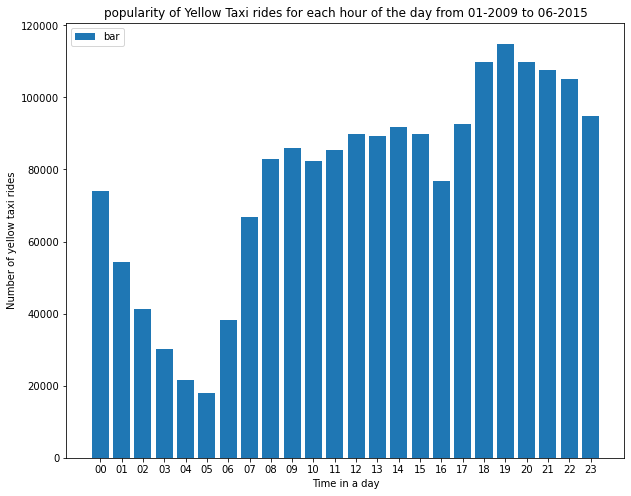

In [403]:
some_dataframe = get_data_for_visual_1()
plot_visual_1(some_dataframe)

#### Extra_credit: Animation for V1

In [438]:
def get_img_list():
    """
    Get an image list for the visualization

    """
    df = get_data_for_visual_1()
    img_list = []
    for i in range(1,24):
        fig = Figure(figsize=(8,2))
        canvas = FigureCanvasAgg(fig)
        dfCurr = df.iloc[:i, :]
        x, y = dfCurr['time'], dfCurr['number']
        ax = fig.subplots(1,1)
        ax.bar(x, y, label='bar')
        ax.set_title('Number of Taxi Trips each hour')  
        ax.set_xlabel('time')
        ax.set_ylabel('number')
        
        ax.legend(frameon=True, loc="upper left")
        canvas.draw()
        rgba = np.asarray(canvas.buffer_rgba())
        img_list.append(rgba)
    return img_list

23


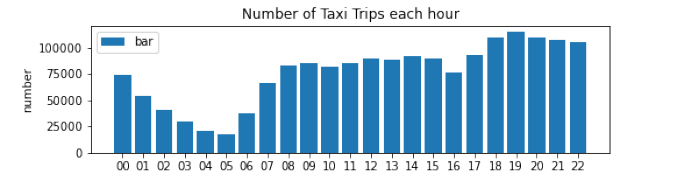

In [439]:
# Showing animation
img_list = get_img_list()
print(len(img_list))
vidname = "Animation_for_V1"
fps = 16
fig = plt.figure(figsize=(12,8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=10000,blit=True) 
HTML(ani.to_jshtml())

### Visualization 2

### Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.


In [383]:
def get_data_for_visual_2(engine):
    """
    Get avg taxi and uber data per month
    
    """
    
    taxi = """
    SELECT strftime ('%m', pickup_datetime) AS month, 
    AVG(distance) as avg_dis,
    distance as dis
    FROM taxi_trips
    GROUP BY month
    """
    uber = """
    SELECT strftime ('%m', pickup_datetime) AS month,
    AVG(distance) as avg_dis,
    distance as dis
    FROM uber_trips
    GROUP BY month
    """
    avg_taxi_distance = pd.read_sql_query(taxi, engine)
    avg_uber_distance = pd.read_sql_query(uber, engine)
    avg_taxi_distance.dropna()
    avg_uber_distance.dropna()
    return avg_taxi_distance,avg_uber_distance

In [384]:
engine.execute("""
              SELECT strftime ('%m', pickup_datetime) AS month, 
              AVG(distance) as avg_dis,
              distance as dis
              FROM taxi_trips
              GROUP BY month
              """).fetchall()

[('01', 3.4122688482907013, 1.756277958572788),
 ('02', 3.3946154912028605, 4.134755325380963),
 ('03', 3.527000465493444, 7.564422138492724),
 ('04', 3.466139948257488, 2.7890682027734366),
 ('05', 3.651777462654599, 3.6568337391793473),
 ('06', 3.5479520912432196, 12.947297841504907),
 ('07', 3.5697800822788572, 7.777086183216217),
 ('08', 3.5836912640157226, 1.6330540371494828),
 ('09', 3.5976827570001646, 3.2029281147153115),
 ('10', 3.5529968933909153, 2.0752159347705152),
 ('11', 3.555224381718069, 1.16547101228899),
 ('12', 3.5026195028803175, 0.8701217628836682)]

In [385]:
def plot_visual_2(t,u): 
    """
    Plot the visualization with 90% CI
    
    """
    #calculate standard deviation
    taxi_std = np.std(t['dis'])
    uber_std = np.std(u['dis'])
    
    # plot lines for taxi and uber
    plt.plot(t['month'], t['avg_dis'], label='Taxi', color='red')
    plt.plot(u['month'], u['avg_dis'], label='Uber', color='blue')
    
    # calculate 90% CI: assuming normal distribution    
    plt.fill_between(t['month'], t['avg_dis']-1.645*taxi_std, t['avg_dis']+1.645*taxi_std, color='red', alpha=0.1)
    plt.fill_between(u['month'], u['avg_dis']-1.645*uber_std, u['avg_dis']+1.645*uber_std, color='blue', alpha=0.1)

    # Set x-axis, y-axis label and title
    plt.xlabel('Month')
    plt.ylabel('Average Distance Travelled')
    plt.title('Average distance travelled per month with 90% CI')
    plt.legend(frameon=True, loc="upper left")
    plt.show()

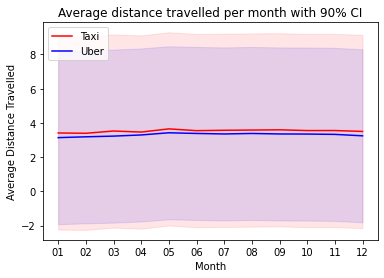

In [386]:
t,u = get_data_for_visual_2(engine)
plot_visual_2(t,u)

### Visualization 3

### Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.  

In [387]:
def get_data_for_visual_3():
    """
    Define three boxes and return a dataframe of dropoffs
    
    """
    
    boxes = {
        "LGA": [-73.889473,40.766102,-73.857630,40.782806],
        "JFK" : [-73.826978,40.618945,-73.741319,40.673388],
        "EWR" : [-74.199343,40.668791,-74.150248,40.712069]}
    df = pd.DataFrame(index=range(7))
    
    for (addr, box) in boxes.items():
        query=f"""
        WITH data AS
        (SELECT pickup_datetime, dropoff_latitude, dropoff_longitude FROM uber_trips 
        UNION ALL
        SELECT pickup_datetime, dropoff_latitude, dropoff_longitude FROM taxi_trips)
        
        SELECT count(*) AS {addr}, strftime('%w', pickup_datetime) AS `day_of_week` 
        FROM data WHERE dropoff_longitude>={box[0]} and dropoff_latitude>={box[1]}
        and dropoff_longitude<={box[2]} and dropoff_latitude<={box[3]} 
        GROUP BY `day_of_week`"""
        
        dt = pd.read_sql_query(query, engine)
        df = pd.concat([df, dt.iloc[:, 0]], axis=1)
    df = pd.DataFrame(df)
    df.index = df.index.map(lambda x: x+1)    
    return df

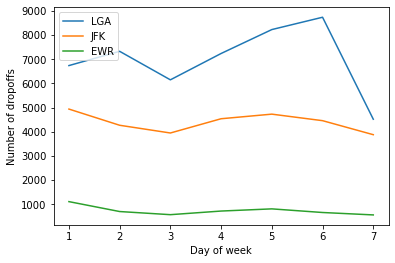

In [388]:
df = get_data_for_visual_3()

plt.plot(df.index, df['LGA'], label='LGA')
plt.plot(df.index, df['JFK'], label='JFK')
plt.plot(df.index, df['EWR'], label='EWR')
plt.legend(loc="upper left")
plt.xlabel('Day of week')
plt.ylabel('Number of dropoffs')
plt.show()

### Visualization 4
### Create a heatmap of all hired trips over a map of the area. Consider using Folium or KeplerGL or another library that helps generate geospatial visualizations.

In [440]:
def get_data_for_visual_4():
    """
    Write a query to get geo data
    
    """
    
    grf = gpd.read_file(filename='taxi_zones/taxi_zones.shp', engine='fiona')
    grf = grf.to_crs(4326)
    grf['longitude'] = grf.centroid.x
    grf['latitude'] = grf.centroid.y
    
    # write queries to fetch latitude and longitude from trips
    Query = """
            SELECT pickup_latitude, 
            pickup_longitude
            FROM uber_trips
            UNION ALL
            SELECT pickup_latitude, 
            pickup_longitude 
            FROM taxi_trips
            """
    data = pd.read_sql_query(query, engine)
    geoData = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.pickup_longitude, data.pickup_latitude))
    data = grf.sjoin(geoData, how="left", predicate="contains")
    
    # count number of rides
    countData = data.groupby(by=["OBJECTID"])["OBJECTID"].count()
    countData.reset_index(inplace=True, drop=True)
    grf = grf.assign(count=countData)
    
    return grf

In [390]:
def all_hired_trips_heatmap():
    """
    visualize with the heatmap
    
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    df = get_data_for_visual_4()
    df.plot(column='count', scheme="MaxP", k=8, ax=ax, cmap='Pastel2',legend=True,
            missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"},
            legend_kwds={"bbox_to_anchor" :(1.8, 1)})


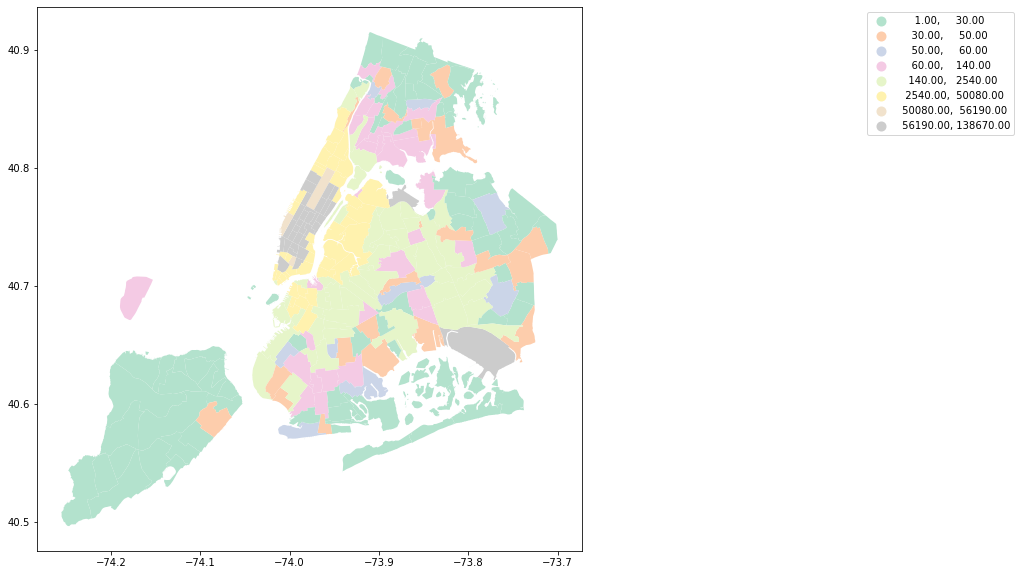

In [391]:
all_hired_trips_heatmap()

In [392]:
heat_map = KeplerGl()
heat_map.add_data(data=get_data_for_visual_4(), name="count")
heat_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'count': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2…

### Visualization 5
### Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. 

In [441]:
def scatter_tip_distance(df):
    """
    Create a scatter plot of tip amount VS distance
    
    """
    df = df[df['tip_amount']>0] # get the tips amount which are greater than 0
    df = df.sample(1000)
    
    fig = plt.figure(figsize=(15, 9))
    plt.scatter(df['distance'], df['tip_amount'])
    
    plt.xlabel('Distance')
    plt.ylabel('Tip amount')
    plt.title('Scatter for tip amount and distance')    
    plt.show()

In [442]:
def get_data_for_visual_5():
    '''
    Get data by sql statement
    
    '''
    query_5 = """
            SELECT tip_amount,
            distance 
            FROM taxi_trips
            """
    df = pd.read_sql_query(query_5, engine)
    return df

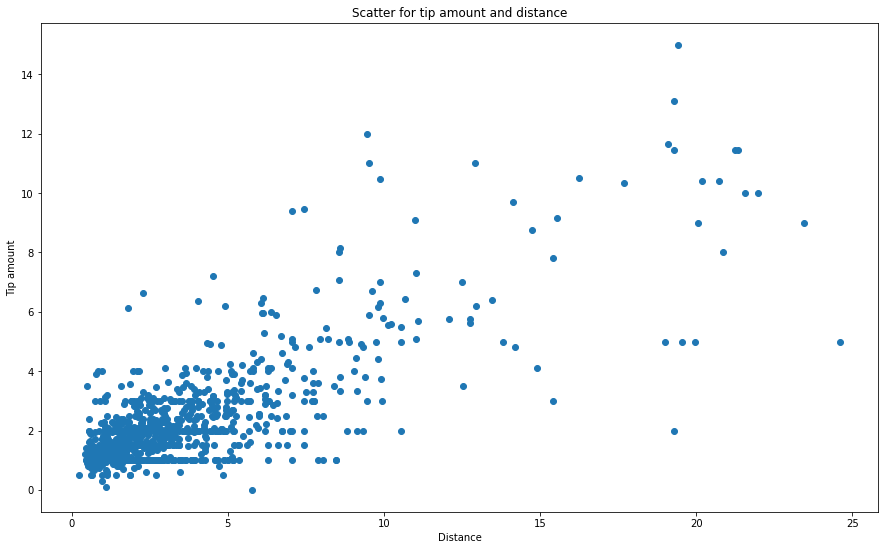

In [443]:
df5 = get_data_for_visual_5()
scatter_tip_distance(df5)

### Visualization 6
### Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. 

In [444]:
def scatter_tip_precipitation(df):
    """
    Create a scatter plot of tip amount VS precipitation
    
    """
    df = df[df['tip_amount']>0] # filter tips which are greater than zero 
    fig = plt.figure(figsize=(15, 9))
    
    plt.scatter(df['HourlyPrecipitation'], df['tip_amount'])
    plt.xlabel('Precipitation')
    plt.ylabel('Tip amount')
    plt.title('Scatter for tip amount and precipitation')    
    plt.show()

In [445]:
def get_data_for_visual_6():
    """
    Get data of tip amount and precipitation
    
    """
    query_tip = """
                 SELECT tip_amount,
                 strftime('%Y-%m-%d %H', pickup_datetime) AS date
                 FROM taxi_trips
                """
    
    query_rain = """
                 SELECT HourlyPrecipitation, 
                 strftime('%Y-%m-%d %H', DATE) AS date
                 FROM hourly_weather
                 """
    df_tip = pd.read_sql_query(query_tip, engine)
    df_rain = pd.read_sql_query(query_rain, engine)
    df = pd.merge(df_tip, df_rain, on='date')
    df = df.drop('date',axis=1)
    
    return df

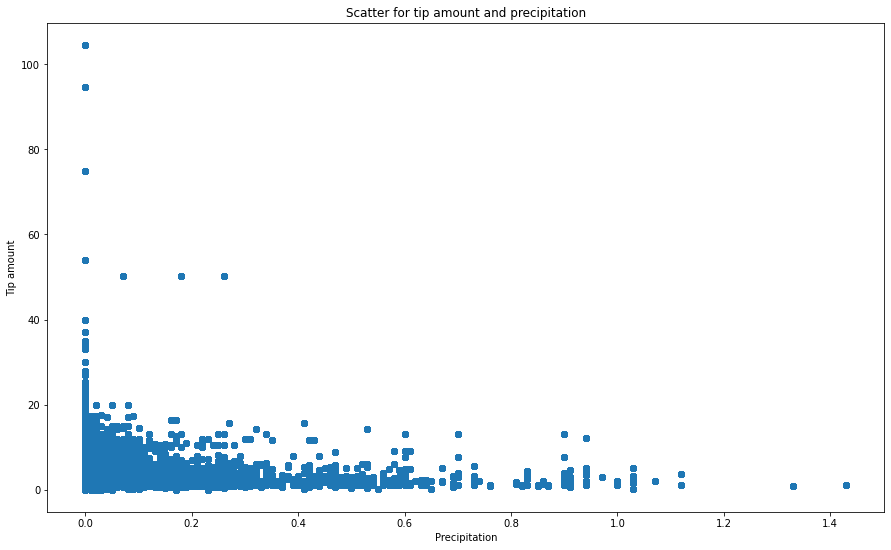

In [446]:
df6 = get_data_for_visual_6()
scatter_tip_precipitation(df6)